<img src="https://3a2vzv37nkuw3esf6a3u2t7s-wpengine.netdna-ssl.com/webcentral/wp-content/uploads/sites/267/2019/02/horizontaldarkbackground.jpg" width="55%" align="left"> 
<br><br><br><br><br>
<font size=3 color='#08088A'>
<b>CSCI250 Python Computing: Building a Sensor System</b> <br><br>
Capstone final report
</font>
<hr style="height:5px" width="55%" align="left">

# Title

Insert one or more pictures of your project. 
You can do this by clicking **Edit** in the menu bar, then **Insert Image**.

# Group 

List all members and indicate specific project responsibilities:

* Tobin Ford, flex/pressure sensors, climbing, data analysis
* Alexander Capehart, accelerometers, climbing, data analysis

# Description

Our project a sensor system that can be attached to a climber to record biometrics during climbing.

# Hardware

- 5x Accelerometers
- 1x Qwiic Mux (To combine Accelerometers)
- 2x Pressure Sensors
- 2x Flex sensors

# Operation

- Attach Accelerometers to Mux, make sure to daisy chain jumpers so they span across all limbs
- Attach sensor system to climber, connect to RPi
- Run "data collection" part of this notebook when the climber starts climbing
- Specify the files to read in the "data analysis" part of this notebook

# Data

As stated in the capstone guidelines notebook, your project must have 4 data components:

1. **Collect** data
2. **Process** data
3. **Display** data
4. **Interpret** data

Include a description of the data you collected, what processing you did, graphs/plots/visuals created by your code, and your interpretation/analysis of the data. 

There is no need to include raw data unless it helps your explanation.

**Data collected:**
- Acceleration from all 5 limbs and center of mass
- Pressure from soles of feet
- Flex of knees

**Data processed:**
- Acceleration smoothed out with outliers removed
- Numeric integration and derivation performed on acceleration to determine jerk, velocity, position
- Flex sensor and pressure sensor data cleaned to remove floating/indeterminant values

**Data displayed:**
- Raw and smoothed out acceleration
- Pressure sensor and flex sensor results, as a graph and as a diagram over time
- Jerk, velocity, position acceleration data as a graph
- Animated "Person" diagram using position data and velocity vectors

# Wiring

Include a a description or schematic of how all hardware elements are connected to your RPi. Be specific about what is connected where. There are several websites that allow you to create circuit schematics for free, such as [this one](https://www.circuit-diagram.org/editor/).

# Code

In [ ]:
# imports
import time                         # Time access and conversion package
import qwiic_i2c                    # I2C bus driver package
import qwiic_tca9548a
import accUtil as acc
import numpy as np
import time
import pandas as pd

import numpy as np
import adcUtil as adc
import time
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
ACCELEROMETERS_OUT_FILE = "accelerometers5.npy"
FLEX_SENSORS_OUT_FILE = "flexSensors5.npy"
PRESSURE_SENSORS_OUT_FILE = "pressureSensors5.npy"

In [ ]:
class Accelerometers():
    def __init__(self, n = 5):
        self.n = n
        self.data = np.zeros( [ 0, 1 + self.n * 3 ]) # cols = time + accelerometer amount
        self.calibration = np.zeros(1 + self.n * 3)
        self.mux = qwiic_tca9548a.QwiicTCA9548A(address=0x70, i2c_driver=qwiic_i2c.getI2CDriver())
        self.tref = 0
        self.absolute = np.zeros(1 + self.n * 3)
       
    def calibrate(self, tref, absolute = np.array([ 0, 0, 9.81 ])):
        self.tref = tref
        self.absolute = np.pad(np.tile(absolute, self.n), (1, 0), constant_values=(0))
        self.__read(self.calibration)

    def table(self):
        return pd.DataFrame(data=self.data)
        
    def record(self):
        self.data.resize((len(self.data) + 1, 1 + self.n * 3))
        self.data[-1][0] = time.time() - self.tref
        self.__read(self.data[-1])
        self.data[-1] = self.data[-1] - self.calibration + self.absolute
        
    def __read(self, row):
        for i in range(self.n):
            self.mux.disable_all()
            self.mux.enable_channels([i])
            x, y, z = acc.readACC(model="MMA8452Q")
            row[i * 3 + 1] = x
            row[i * 3 + 2] = y
            row[i * 3 + 3] = z
        return row
    
    def save(self, filename="accelerometers.npy"):
         np.save(filename, self.data)

In [ ]:
class ResistanceSensors():
    def __init__(self, dev, n = 2, vin = 3.3, r2 = 10.0):
        self.dev = dev
        self.n = n
        self.vin = vin
        self.r2 = r2 
        self.tref = 0
        self.data = np.zeros( [ 0, 1 + self.n ], dtype=float) # cols = time + accelerometer amount
    
    def calibrate(self, tref):
        self.tref = tref
        
    def table(self):
        return pd.DataFrame(data=self.data)
        
    def record(self):
        self.data.resize((len(self.data) + 1, 1 + self.n))
        row = self.data[-1]
        row[0] = time.time() - self.tref
        for i in range(self.n):
            vou = adc.readADC(channel=i, device=self.dev)
            row[i + 1] = vou
    
    def save(self, filename):
         np.save(filename, self.data)

In [ ]:
accs = Accelerometers()
pressureSensors = ResistanceSensors(0)
flexSensors = ResistanceSensors(1)

tref = time.time()
flexSensors.calibrate(tref)
pressureSensors.calibrate(tref)
accs.calibrate(tref)

while time.time() - tref < 60:
    accs.record()
    pressureSensors.record()
    flexSensors.record()

flexSensors.save(FLEX_SENSORS_OUT_FILE)
pressureSensors.save(PRESSURE_SENSORS_OUT_FILE)
accs.save(ACCELEROMETERS_OUT_FILE)

accs.table().head()

In [2]:
ACCELEROMETERS_IN_FILE = "accelerometers.npy"
FLEX_SENSORS_IN_FILE = "flexSensors.npy"
PRESSURE_SENSORS_IN_FILE = "pressureSensors.npy"

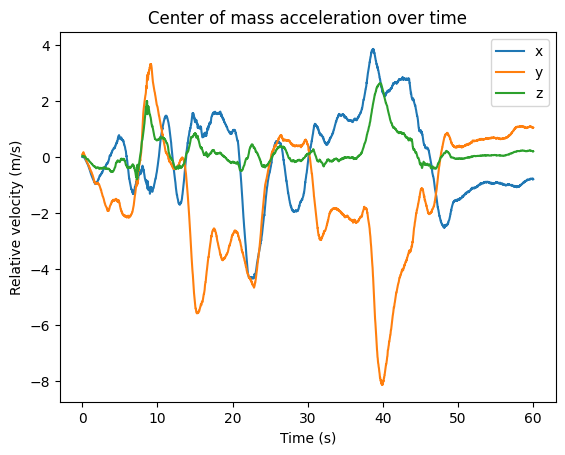

In [13]:

raw_accs = np.load(ACCELEROMETERS_IN_FILE)
adj = np.pad(np.tile([0, 0, -9.81], 5), (1, 0), constant_values=(0))
raw_accs += adj
WINDOW_SIZE = 128

smoothed_accs = np.empty(raw_accs.shape, dtype=float)
smoothed_accs[:, 0] = raw_accs[:, 0]
for i in range(len(raw_accs)):
    if i < WINDOW_SIZE // 2:
        # Window isn't complete yet, just take the latter half and whatever
        # comes in the beginning
        right = i + WINDOW_SIZE // 2
        window = raw_accs[:right, 1:]
    elif i + WINDOW_SIZE // 2 >= len(raw_accs):
        left = i - WINDOW_SIZE // 2
        # Can't form full window from remaining data, take whatever data we have
        # before up to the end of the data
        window = raw_accs[left:len(raw_accs), 1:]
    else:
        # Can form full window from both ends.
        left = i - WINDOW_SIZE // 2
        right = i + WINDOW_SIZE // 2
        window = raw_accs[left:right, 1:]
    smoothed_accs[i, 1:] = np.mean(window, axis=0)

plt.plot(smoothed_accs[:,0], smoothed_accs[:, 1:4])
plt.title("Center of mass acceleration over time")
plt.xlabel("Time (s)")
plt.ylabel("Relative velocity (m/s)")
plt.legend(["x","y","z"])

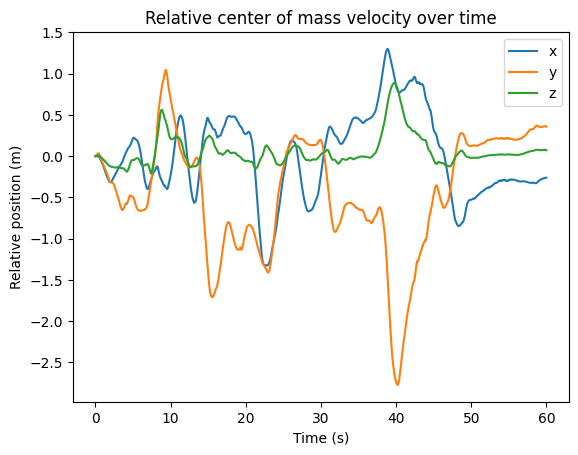

In [14]:
def midpoint_integral(arr):
    out = np.zeros(arr.shape, dtype=float)
    for i in range(1, len(arr)):
        l = max(i - 32, 0)
        r = i
        a = arr[l][0]
        b = arr[r][0]
        n = r - l
        c = (b - a) / (2 * n)
        sli = arr[l:r, 1:]
        f0 = sli[0, :]
        # From 1 to n - 1 maps to from 1 to n - 2 in zero-indexed notation
        sigma = np.sum(sli[1:n - 2, :] * 2, axis=0)
        # f_n maps to f[n - 1] in zero-indexed notation.
        fn = sli[n -  1, :]
        out[i][0] = arr[i][0]
        out[i, 1:] = c * (f0 + sigma + fn)
    return out

vel = midpoint_integral(smoothed_accs)
plt.plot(vel[:,0], vel[:, 1:4])
plt.title("Relative center of mass velocity over time")
plt.xlabel("Time (s)")
plt.ylabel("Relative position (m)")
plt.legend(["x","y","z"])

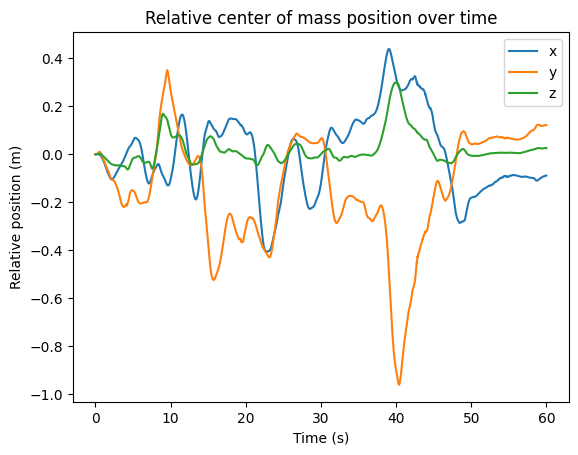

In [15]:

pos = midpoint_integral(vel)
plt.plot(pos[:,0], pos[:, 1:4])
plt.title("Relative center of mass position over time")
plt.xlabel("Time (s)")
plt.ylabel("Relative position (m)")
plt.legend(["x","y","z"])

In [6]:
pressure = np.load("pressureSensors2.npy")

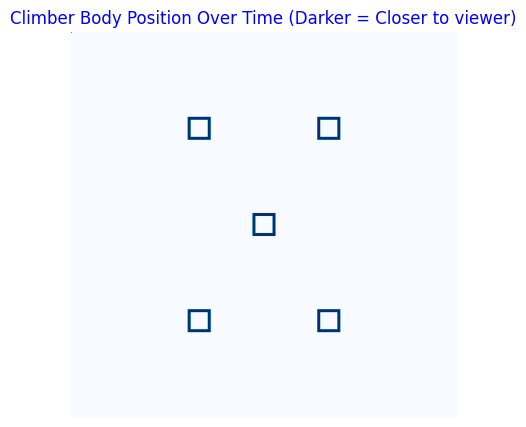

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng

import matplotlib.animation as ani
from IPython.display import HTML

n = 500
nR = 500
nC = 500
nT = 250

MOVIE = np.zeros( [nR,nC,nT], dtype=float)
MOVIE[0][0][0] = 1

MID_ADJ = n // 2
INNER_ADJ = n // 3
OUTER_ADJ = n // 4

LIMB_SIZE = n // 32
HOLE = np.zeros([LIMB_SIZE * 2, LIMB_SIZE * 2])
HOLE[:,:] = 1
HOLE[4:-4, 4:-4] = 0

def coord(c, s):
    adj = int(c * 100)
    if adj > 100:
        adj = 100
    elif adj < -100:
        adj = -100
    return adj + s

def apply(t, start, sx, sy, sz, filled):
    px = coord(pos[t][start], sx)
    py = coord(pos[t][start+1], sy)
    pz = coord(pos[t][start+2], 0)
    if filled:
        MOVIE[py - LIMB_SIZE:py + LIMB_SIZE, px - LIMB_SIZE:px + LIMB_SIZE, i] = 1
    else:
        MOVIE[py - LIMB_SIZE:py + LIMB_SIZE, px - LIMB_SIZE:px + LIMB_SIZE, i] = HOLE * (1 - pz/100)
        
    

for i in range(nT):
    t = int((i/nT)*len(pos))
    apply(t, 1, MID_ADJ, MID_ADJ, 0, False)
    apply(t, 4, nC - INNER_ADJ, nR - OUTER_ADJ, 0, pressure[t][1] > 3.0)
    apply(t, 7, INNER_ADJ, nR - OUTER_ADJ, 0, pressure[t][2] > 3.0)
    apply(t, 10, INNER_ADJ, OUTER_ADJ, 0, False)
    apply(t, 13, nC - INNER_ADJ, OUTER_ADJ, 100, False)

# Create figure twice as wide as tall
golFig = plt.figure(figsize=(10,5))

# Create two subplots
# plt.subplot(1,2,1)
golPlotA = plt.imshow(MOVIE[:,:,0], cmap="Blues") # first frame of AMOVIE 
plt.title("Climber Body Position Over Time (Darker = Closer to viewer)",color='blue')
plt.axis('off');

# Adapt the animation function to support two subplots
def golAnimate(i, MA, PA):
    PA.set_data( MA[:,:,i] )
    plt.axis('off')

# Create inline animation
golMovieA = ani.FuncAnimation(fig   = golFig, 
                            func   = golAnimate, 
                            frames = nT,
                            fargs  = (MOVIE,golPlotA) # pass both plots
                            );

#HTML(golMovieA.to_jshtml())   # Java script version (don't use on RPi)
HTML(golMovieA.to_html5_video()) # HTML 5 (use on RPi)

# Credits

Include references to all code you used in your project. If it's a library, provide name, version and download link.